In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2


In [26]:
from fastai.vision import *
import seaborn as sns

In [3]:
path = Path('train')

In [4]:
fnames = get_image_files(path)
fnames[:3]

[PosixPath('train/0000071d71a0a6f6.jpg'),
 PosixPath('train/000002b66c9c498e.jpg'),
 PosixPath('train/000002c707c9895e.jpg')]

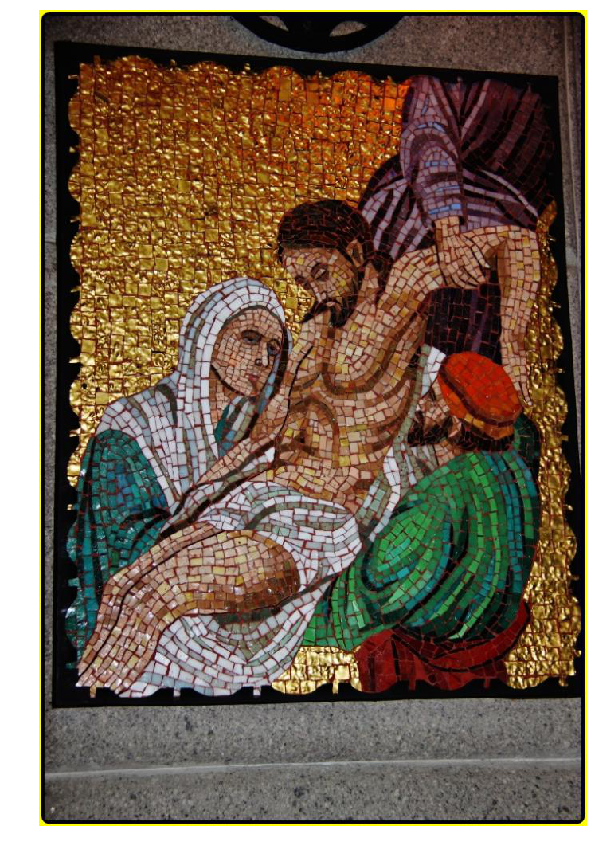

In [5]:
img = open_image(fnames[2])
img.show(figsize=(15,15))

In [6]:
size = 224

In [7]:
def get_CrCb(fn): return Image(open_image(fn, convert_mode="YCbCr").data[1:,...])
class MySegmentationProcessor(PreProcessor):
    "`PreProcessor` that stores the classes for segmentation."
    def __init__(self, ds:ItemList): pass
    def process(self, ds:ItemList):  pass

class MySegmentationLabelList(SegmentationLabelList):
    "`ItemList` for segmentation masks."
    _processor=MySegmentationProcessor
    def __init__(self, items:Iterator, **kwargs):
        super().__init__(items, **kwargs)
        self.loss_func = MSELossFlat(axis=1)

    def open(self, fn): return get_CrCb(fn)
    def analyze_pred(self, pred): return pred
    def reconstruct(self, t:Tensor): return ImageSegment(t)

In [8]:
class MySegmentationItemList(SegmentationItemList):
    _label_cls,_square_show_res = MySegmentationLabelList,False
    def open(self,fn): return Image(open_image(fn, convert_mode="YCbCr").data[:1,...].expand(3,-1,-1))
    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
        rows = int(np.ceil(math.sqrt(len(xs))))
        axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize)
        for x,y,ax in zip(xs, ys, axs.flatten()):
            _y    = (x.px[:1,...].cpu().numpy()*255).astype(np.uint8)
            _CbCr = (y.px[:,...].cpu().numpy()*255).astype(np.uint8)
            yCbCr = np.concatenate([_y, _CbCr], axis=0)
            yCbCr = np.transpose(yCbCr, (1,2,0))
            ax.imshow(PIL.Image.fromarray(yCbCr, mode='YCbCr'))
        for ax in axs.flatten()[len(xs):]: ax.axis('off')
        plt.tight_layout()
    def show_xyzs(self, xs, ys, zs, imgsize:int=8, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`."
        if False:#self._square_show_res:
            title = 'Ground truth\nPredictions'
            rows = int(np.ceil(math.sqrt(len(xs))))
            axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=12)
            for x,y,z,ax in zip(xs,ys,zs,axs.flatten()): x.show(ax=ax, title=f'{str(y)}\n{str(z)}', **kwargs)
            for ax in axs.flatten()[len(xs):]: ax.axis('off')
        else:
            title = 'Ground truth/Predictions'
            axs = subplots(len(xs), 2, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=14)
            for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
                _y    = (x.px[:1,...].cpu().numpy()*255).astype(np.uint8)
                _CbCr = (y.px[:,...].cpu().numpy()*255).astype(np.uint8)
                yCbCr = np.transpose(np.concatenate([_y, _CbCr], axis=0), (1,2,0))
                axs[i,0].imshow(PIL.Image.fromarray(yCbCr, mode='YCbCr'))
                _CbCr = (z.px[:,...].cpu().numpy()*255).astype(np.uint8)
                yCbCr = np.transpose(np.concatenate([_y, _CbCr], axis=0), (1,2,0))
                axs[i,1].imshow(PIL.Image.fromarray(yCbCr, mode='YCbCr'))

In [9]:
src = MySegmentationItemList.from_folder(path).random_split_by_pct(0.2).label_from_func(lambda x:x)

In [10]:
get_transforms(max_lighting=None)

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)])

In [11]:
size = 224
bs = 24
data = (src.transform(get_transforms(max_lighting=None,xtra_tfms=rand_resize_crop(size)), size=size, tfm_y=True,) #*
        .databunch(bs=bs)
        .normalize())

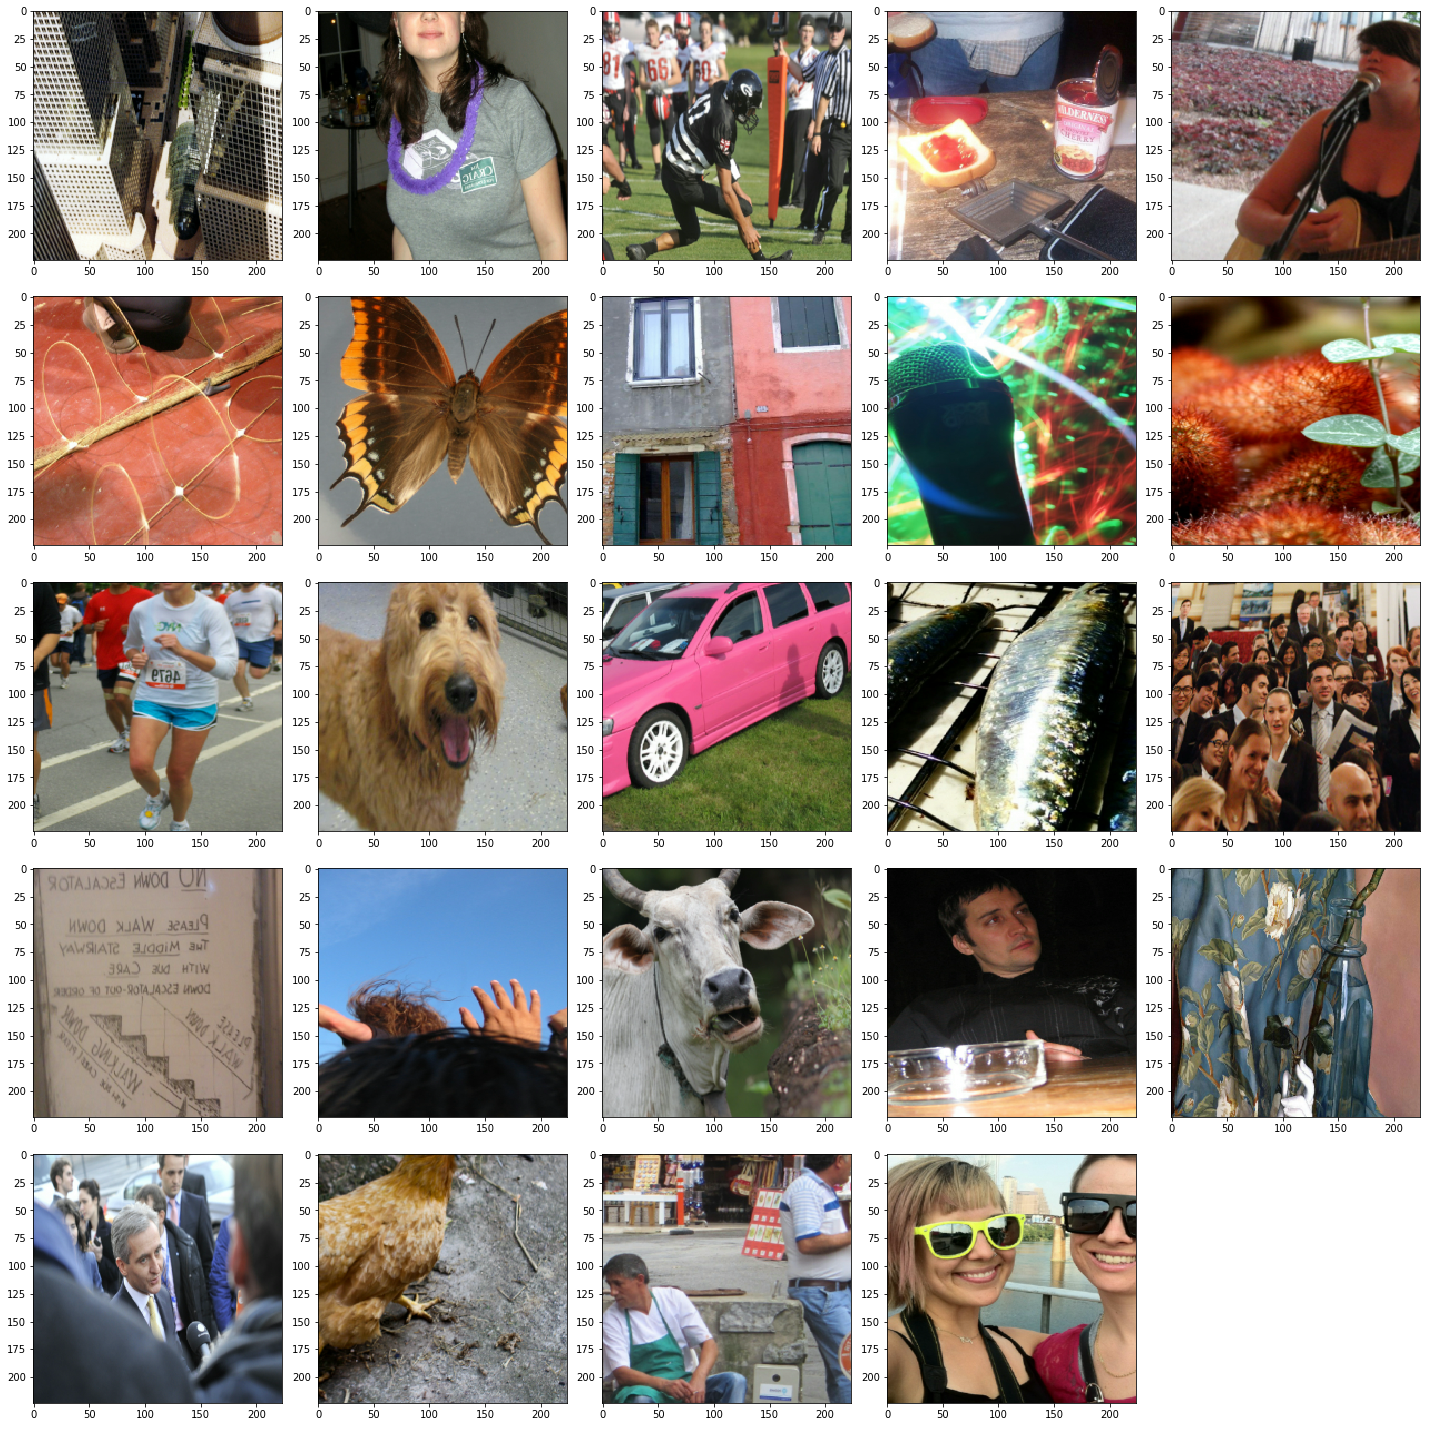

In [12]:
data.show_batch(10)
data.c=2

In [13]:
learn = unet_learner(data, models.resnet34, blur_final=False, y_range=(0,1.))#.to_fp16()
learn.unfreeze()

In [14]:
#learn.load('w1')
learn.model

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-05


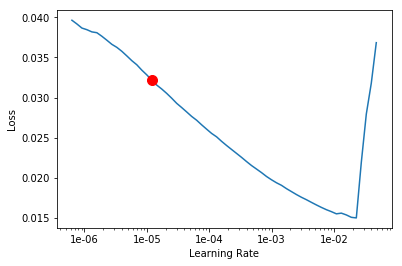

In [15]:
lr_find(learn)
lr = learn.recorder.plot()


In [16]:
learn.fit_one_cycle(1,max_lr=2e-5)

KeyboardInterrupt: 

In [42]:
learn.save('w1', return_path=True)

PosixPath('train/models/w1.pth')

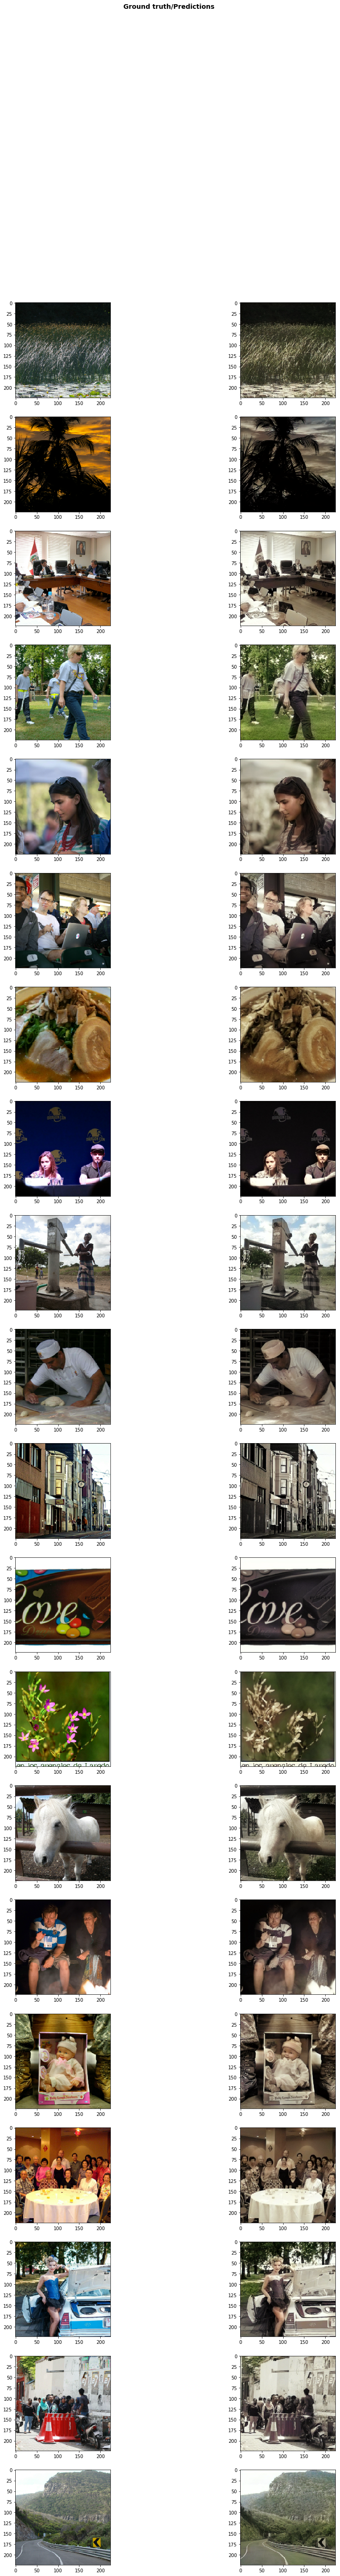

In [18]:
learn.show_results(rows=20, figsize=(16,9*10))

In [39]:
vals = data.train_ds[10][1].data[0].cpu().numpy().flatten()

In [40]:
vals.shape

(50176,)

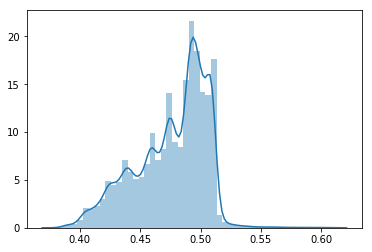

In [41]:
sns.distplot(vals)